In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [203]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [204]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'
# path = '/GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis'
# /GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis
# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [205]:
train.sample()

,Provider,PotentialFraud
1693,PRV53114,Yes


In [206]:
inpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
20494,BENE86165,CLM55836,2009-06-16,2009-06-23,PRV55916,10000,PHY417910,PHY407957,NaN,2009-06-16,5712,1068.0,2009-06-23,435,5712,40390,5722,51881,27651,42832,5723,2761,30391,42731,4516.0,NaN,NaN,NaN,NaN,NaN


In [207]:
inpatient['Provider'].nunique()

2092

In [208]:
df = inpatient.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index().rename(columns={'InscClaimAmtReimbursed': 'IPReimbursmentTotal'})
df

,Provider,IPReimbursmentTotal
0,PRV51001,97000
1,PRV51003,573000
2,PRV51007,19000
3,PRV51008,25000
4,PRV51011,5000
...,...,...
2087,PRV57719,76000
2088,PRV57728,6000
2089,PRV57729,107000
2090,PRV57732,76000


In [209]:
outpatient['Provider'].nunique()

5012

In [210]:
out_df = outpatient.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index().rename(columns={'InscClaimAmtReimbursed': 'OPReimbursmentTotal'})
out_df

,Provider,OPReimbursmentTotal
0,PRV51001,7640
1,PRV51003,32670
2,PRV51004,52170
3,PRV51005,280910
4,PRV51007,14710
...,...,...
5007,PRV57759,10640
5008,PRV57760,4770
5009,PRV57761,18470
5010,PRV57762,1900


In [211]:
# Merge IP and OP provider totals
provider_claims = pd.merge(
    df,  # Left: Provider, IP_Claims_Total
    out_df,  # Right: Provider, OP_Claims_Total
    on='Provider',
    how='outer'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [212]:
provider_claims

,Provider,IPReimbursmentTotal,OPReimbursmentTotal
0,PRV51001,97000.0,7640.0
1,PRV51003,573000.0,32670.0
2,PRV51004,0.0,52170.0
3,PRV51005,0.0,280910.0
4,PRV51007,19000.0,14710.0
...,...,...,...
5405,PRV57759,0.0,10640.0
5406,PRV57760,0.0,4770.0
5407,PRV57761,0.0,18470.0
5408,PRV57762,0.0,1900.0


In [ ]:
# provider_claims.to_csv('2draft fraud2.csv', index=False)

In [163]:
provider_claims['IPReimbursmentTotal'].sum()

np.float64(408297020.0)

In [164]:
provider_claims['OPReimbursmentTotal'].sum()

np.float64(148246120.0)

In [165]:
# Then merge with fraud labels
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
)

In [166]:
final_df

,Provider,IPReimbursmentTotal,OPReimbursmentTotal,PotentialFraud
0,PRV51001,97000.0,7640.0,No
1,PRV51003,573000.0,32670.0,Yes
2,PRV51004,0.0,52170.0,No
3,PRV51005,0.0,280910.0,Yes
4,PRV51007,19000.0,14710.0,No
...,...,...,...,...
5405,PRV57759,0.0,10640.0,No
5406,PRV57760,0.0,4770.0,No
5407,PRV57761,0.0,18470.0,No
5408,PRV57762,0.0,1900.0,No


In [167]:
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df


,Provider,IPReimbursmentTotal,OPReimbursmentTotal,PotentialFraud
0,PRV51001,97000.0,7640.0,0
1,PRV51003,573000.0,32670.0,1
2,PRV51004,0.0,52170.0,0
3,PRV51005,0.0,280910.0,1
4,PRV51007,19000.0,14710.0,0
...,...,...,...,...
5405,PRV57759,0.0,10640.0,0
5406,PRV57760,0.0,4770.0,0
5407,PRV57761,0.0,18470.0,0
5408,PRV57762,0.0,1900.0,0


In [168]:
# # Create a csv file with the selected features for later. Only once.
# final_df.to_csv('InscClaimAmtReimbursed_sum.csv', index=False)

# Starting to create the model part

In [169]:
X = final_df[['IPReimbursmentTotal', 'OPReimbursmentTotal']]

In [170]:
y = final_df['PotentialFraud']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [172]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [173]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [174]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

# 4a Make probability
y_proba = model.predict_proba(X_test)[:, 1]


In [175]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[965  12]
 [ 64  41]]


In [176]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.93
Precision: 0.77
Recall: 0.39
F1 Score: 0.52


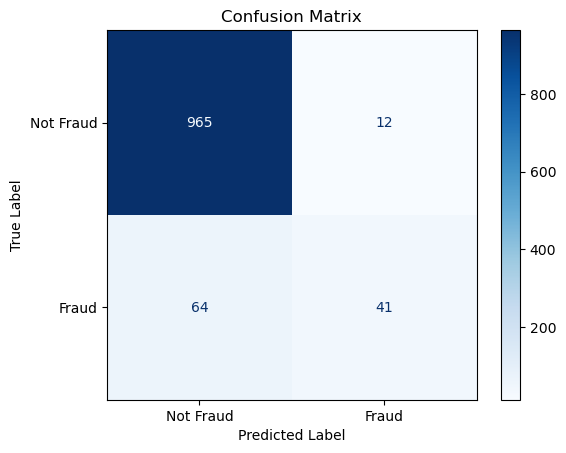

In [177]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

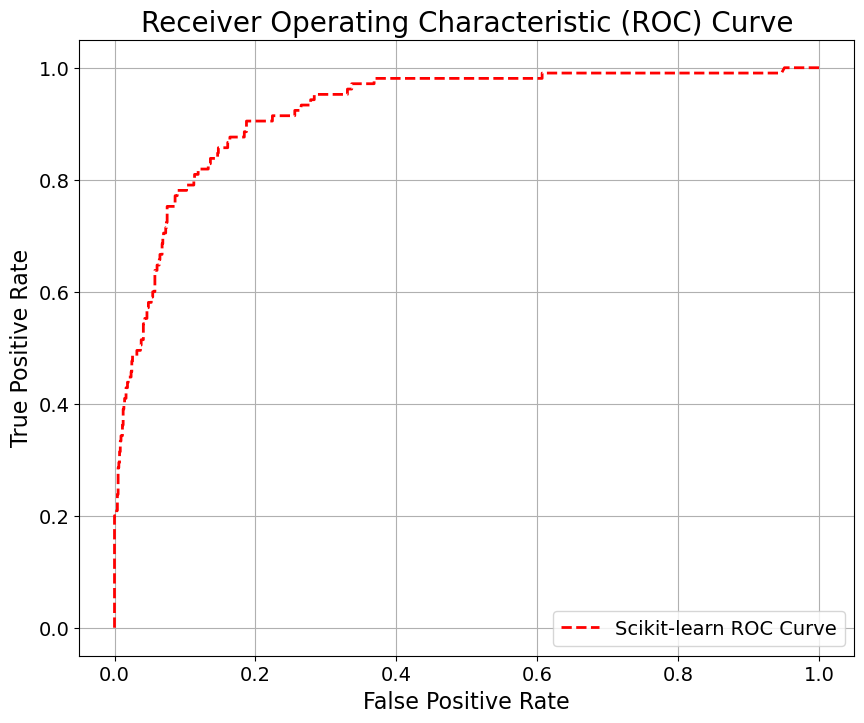

In [178]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [179]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.924038602134815)

### loooking for a better threshold to find better f1 score:
After trying with many combinations, it looks like adjusting the threshold for f1 or anything else, does not give me any relevant improvment compare to the other method I'll do in the next couple of chunks

In [ ]:
# # Get predicted probabilities
# y_proba = model.predict_proba(X_test)[:, 1]

In [88]:
# precicions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# f1_scores = 2 * (precicions * recalls) / (precicions + recalls)
# best_threshold = thresholds[f1_scores.argmax()]
# print(f"Optimal threshold based on F1-score: {best_threshold}")

Optimal threshold based on F1-score: 0.09487004250756263


In [89]:
# # apply the new best threshold to the predicted probabilities
# y_pred_custom = (y_proba >= best_threshold).astype(int)
# # Compute confusion matrix
# cm = confusion_matrix(y_test, y_pred_custom)
# print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[904  73]
 [ 26  79]]


In [90]:
# # flatten the confusion matrix and break it down into four components.
# TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')
# # Calculating metrics
# accuracy = accuracy_score(y_test, y_pred_custom) # 2 ways to calculate accuracy
# accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
# print(f'Accuracy: {accuracy:.2f}')
# precision = TP / (TP + FP) if (TP + FP) != 0 else 0
# print(f'Precision: {precision:.2f}')
# recall = TP / (TP + FN) if (TP + FN) != 0 else 0
# print(f'Recall: {recall:.2f}')
# f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
# print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.91
Precision: 0.52
Recall: 0.75
F1 Score: 0.61


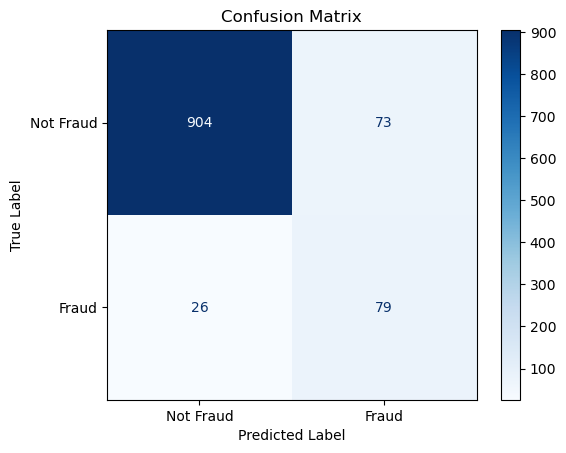

In [91]:
# from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# # Compute and display confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# Apply cross validation

In [92]:
X

,IPReimbursmentTotal,OPReimbursmentTotal
0,97000.0,7640.0
1,573000.0,32670.0
2,0.0,52170.0
3,0.0,280910.0
4,19000.0,14710.0
...,...,...
5405,0.0,10640.0
5406,0.0,4770.0
5407,0.0,18470.0
5408,0.0,1900.0


In [93]:
y

0       0
1       1
2       0
3       1
4       0
       ..
5405    0
5406    0
5407    0
5408    0
5409    0
Name: PotentialFraud, Length: 5410, dtype: int64

In [183]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Define Logistic Regression model
model = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")


Cross-validation scores: [0.94592303 0.94803242 0.9229267  0.93392275 0.93482893]
Mean accuracy: 0.9371


## Hyperparameter Tuning Using `GridSearchCV`

In [184]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Perform GridSearchCV optimizing for recall
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best parameters and recall score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Recall Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best Recall Score: 0.9404


In [185]:
from sklearn.metrics import classification_report

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)


              precision    recall  f1-score   support

   Not Fraud       0.93      0.99      0.96       977
       Fraud       0.80      0.31      0.45       105

    accuracy                           0.93      1082
   macro avg       0.87      0.65      0.71      1082
weighted avg       0.92      0.93      0.91      1082



In [186]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[969,   8],
       [ 72,  33]])

In [187]:
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall', n_jobs=-1)


In [188]:
# from sklearn.metrics import make_scorer, fbeta_score
# custom_scorer = make_scorer(fbeta_score, beta=2)


In [189]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer, fbeta_score
# from sklearn.linear_model import LogisticRegression

# # Define custom scorer (F-beta score with beta=2, which favors recall)
# custom_scorer = make_scorer(fbeta_score, beta=2)

# # Define hyperparameter grid
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
#     'penalty': ['l1', 'l2'],  # Regularization type
#     'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
# }

# # Define logistic regression model
# model = LogisticRegression(max_iter=1000)

# # Use GridSearchCV with the custom scorer
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_scorer, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Print the best parameters & best F-beta score
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best F2 Score: {grid_search.best_score_:.4f}")


In [190]:
final_df.head()

,Provider,IPReimbursmentTotal,OPReimbursmentTotal,PotentialFraud
0,PRV51001,97000.0,7640.0,0
1,PRV51003,573000.0,32670.0,1
2,PRV51004,0.0,52170.0,0
3,PRV51005,0.0,280910.0,1
4,PRV51007,19000.0,14710.0,0


In [191]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = final_df.drop(columns=['Provider','PotentialFraud'])
y = final_df['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [192]:
model_after_smote = LogisticRegression(max_iter=10000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=10000)

In [193]:
from sklearn.metrics import classification_report

# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


In [194]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[887  94]
 [ 18  83]]


In [195]:
# print('Confusion Matrix before manipulating by adding the threshold:\n')
# cm = confusion_matrix(y_test, y_pred)

# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.90
Precision: 0.47
Recall: 0.82
F1 Score: 0.60


In [196]:
from sklearn.metrics import roc_auc_score

y_proba = model_after_smote.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9535


In [197]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for recall
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}


In [198]:
from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9536


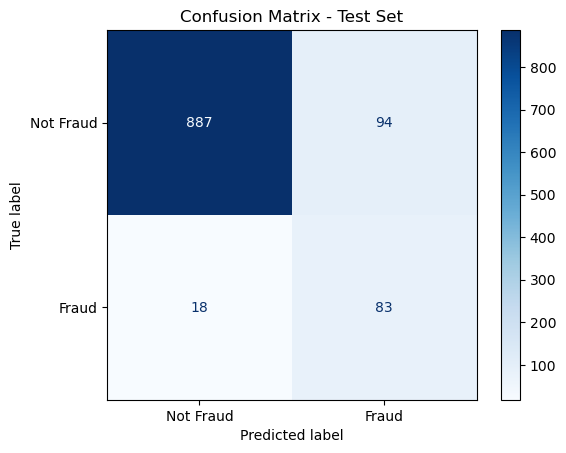

In [199]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [200]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[887  94]
 [ 18  83]]


In [201]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.90
Precision: 0.47
Recall: 0.82
F1 Score: 0.60


In [63]:
# X_test

,IPReimbursmentTotal,OPReimbursmentTotal
1266,0.0,158670.0
1394,0.0,4410.0
1862,0.0,2920.0
1736,5000.0,3960.0
4138,0.0,2600.0
...,...,...
1706,75000.0,7550.0
158,0.0,9910.0
3543,0.0,23140.0
4275,0.0,16050.0


In [ ]:
# # 4. Make predictions on the test set.
# y_predict = best_model.predict(X_test)  # Outputs predicted class labels (0 or 1)

# # 4a Make probability
# y_proba = best_model.predict_proba(X_test)[:, 1]


In [65]:
# from sklearn.metrics import confusion_matrix
# # Assuming y_test contains true labels and y_predict contains predicted labels
# cm = confusion_matrix(y_test, y_predict)
# print("Confusion Matrix:")
# print(cm)

Confusion Matrix:
[[  3 978]
 [  0 101]]


In [66]:
# print(accuracy_score(y_test, y_predict))

0.09611829944547134


In [67]:
# TN, FP, FN, TP = cm.ravel()
# recall = TP / (TP + FN) if (TP + FN) != 0 else 0
# print(f'{recall:.4f}')

1.0000


In [68]:
# from sklearn.metrics import roc_auc_score

# y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
# auc_score = roc_auc_score(y_test, y_proba)

# print(f"ROC-AUC Score: {auc_score:.4f}")

ROC-AUC Score: 0.9536


In [ ]:
# 

In [ ]:
# 

In [ ]:
# 

In [75]:
# # Train the best model found in GridSearchCV
# best_model = grid_search.best_estimator_

# # Predict on test set
# y_pred = best_model.predict(X_test)

# # Evaluate accuracy
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9030


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
